# 1. Introduction

Using NLP and techniques of supervised learning (including Deep
Learning) and unsupervised learning (emphasizing on unsupervised
for this project), and collect thousand texts from Gutenberg project
(and 7 novels) for at least 10 authors, build a project to classify
text-author. The project should follow the guideline as:

    1. Pre-process data using Spacy and other methods.
    2. Perform data exploration
    3. Using Bag of Word, apply supervised models such as Naive
    Bayes, Logistic Regression, Decision Tree, Random Forest,
    KNN, SVM and Gradient Boosting, including GridSearchCV.
    4. Similar to 3., but using TF-IDF.
    5. Similar to 3., but using word2vec.
    6. Appy RNN to do classification.
    7. Using unsupervised technique, visualize bar graphs for clusters
    containing 10 author documents. Adjust by silhouette scores.
    8. Using LSA, LDA and NNMF, print out top ten words (with their
    highest loading) for each topic modeling. Analyze and compare
    among three methods.
    9. Write up analysis and conclusions.

# 2. Import Library

In [241]:
import logging
import numpy as np
import pandas as pd
from time import time  # To time our operations
import nltk
from nltk.corpus import webtext
#to remove HTML tags from the doc
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from collections import defaultdict  # For word frequency

# for visualise the word2vec model
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# 3.  Download gutenberg

In [6]:
# nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.


True

In [15]:
gutenberg_files = nltk.corpus.gutenberg.fileids()
print(gutenberg_files)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [16]:
len(gutenberg_files)

18

In [20]:
blake_words = nltk.corpus.gutenberg.words('blake-poems.txt')
print(len(blake_words))

8354


In [23]:
# nltk.download('punkt')
macbeth_sentences = gutenberg.sents('blake-poems.txt')
macbeth_sentences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


[['[', 'Poems', 'by', 'William', 'Blake', '1789', ']'], ['SONGS', 'OF', 'INNOCENCE', 'AND', 'OF', 'EXPERIENCE', 'and', 'THE', 'BOOK', 'of', 'THEL'], ...]

In [27]:
# macbeth_sentences[1]

In [25]:
# num_words = gutenberg.words('blake-poems.txt')

In [28]:
# num_words[1]

In [15]:
nltk.corpus.gutenberg.raw('blake-poems.txt')

'[Poems by William Blake 1789]\n\n \nSONGS OF INNOCENCE AND OF EXPERIENCE\nand THE BOOK of THEL\n\n\n SONGS OF INNOCENCE\n \n \n INTRODUCTION\n \n Piping down the valleys wild,\n   Piping songs of pleasant glee,\n On a cloud I saw a child,\n   And he laughing said to me:\n \n "Pipe a song about a Lamb!"\n   So I piped with merry cheer.\n "Piper, pipe that song again;"\n   So I piped: he wept to hear.\n \n "Drop thy pipe, thy happy pipe;\n   Sing thy songs of happy cheer:!"\n So I sang the same again,\n   While he wept with joy to hear.\n \n "Piper, sit thee down and write\n   In a book, that all may read."\n So he vanish\'d from my sight;\n   And I pluck\'d a hollow reed,\n \n And I made a rural pen,\n   And I stain\'d the water clear,\n And I wrote my happy songs\n   Every child may joy to hear.\n \n \n THE SHEPHERD\n \n How sweet is the Shepherd\'s sweet lot!\n From the morn to the evening he stays;\n He shall follow his sheep all the day,\n And his tongue shall be filled with praise

In [5]:
# html tags and comments are removed and stored in sample1

sample1 = BeautifulSoup(nltk.corpus.gutenberg.raw('blake-poems.txt') ,"html.parser")

# using get_text() we can see only text in html doc

print(sample1.get_text())

[Poems by William Blake 1789]

 
SONGS OF INNOCENCE AND OF EXPERIENCE
and THE BOOK of THEL


 SONGS OF INNOCENCE
 
 
 INTRODUCTION
 
 Piping down the valleys wild,
   Piping songs of pleasant glee,
 On a cloud I saw a child,
   And he laughing said to me:
 
 "Pipe a song about a Lamb!"
   So I piped with merry cheer.
 "Piper, pipe that song again;"
   So I piped: he wept to hear.
 
 "Drop thy pipe, thy happy pipe;
   Sing thy songs of happy cheer:!"
 So I sang the same again,
   While he wept with joy to hear.
 
 "Piper, sit thee down and write
   In a book, that all may read."
 So he vanish'd from my sight;
   And I pluck'd a hollow reed,
 
 And I made a rural pen,
   And I stain'd the water clear,
 And I wrote my happy songs
   Every child may joy to hear.
 
 
 THE SHEPHERD
 
 How sweet is the Shepherd's sweet lot!
 From the morn to the evening he stays;
 He shall follow his sheep all the day,
 And his tongue shall be filled with praise.
 
 For he hears the lambs' innocent call,
 And

In [6]:
# a '^' within square brackets searches anything other than the one on it
# hence here it matches everything from numbers and punctuations etc , leaving only the words

letters_only = re.sub("[^a-zA-Z]"," ",sample1.get_text())
print(letters_only)

 Poems by William Blake          SONGS OF INNOCENCE AND OF EXPERIENCE and THE BOOK of THEL    SONGS OF INNOCENCE      INTRODUCTION    Piping down the valleys wild     Piping songs of pleasant glee   On a cloud I saw a child     And he laughing said to me      Pipe a song about a Lamb      So I piped with merry cheer    Piper  pipe that song again      So I piped  he wept to hear      Drop thy pipe  thy happy pipe     Sing thy songs of happy cheer     So I sang the same again     While he wept with joy to hear      Piper  sit thee down and write    In a book  that all may read    So he vanish d from my sight     And I pluck d a hollow reed     And I made a rural pen     And I stain d the water clear   And I wrote my happy songs    Every child may joy to hear       THE SHEPHERD    How sweet is the Shepherd s sweet lot   From the morn to the evening he stays   He shall follow his sheep all the day   And his tongue shall be filled with praise     For he hears the lambs  innocent call   And

In [7]:
# changing all the words to lowercase to create a bag of words later

lower_case = letters_only.lower()

# the whole doc is now split to create an array from which most common words called "stop words" will be removed

words = lower_case.split()

In [20]:
# nltk.download('stopwords')

# most common stopwords used in english language

print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  Stop words

In [8]:
# removing  stopwords from sample1 so that relevant words can be filtered out and stored in words

words = [w for w in words if w not in stopwords.words("english")]
print(words)

['poems', 'william', 'blake', 'songs', 'innocence', 'experience', 'book', 'thel', 'songs', 'innocence', 'introduction', 'piping', 'valleys', 'wild', 'piping', 'songs', 'pleasant', 'glee', 'cloud', 'saw', 'child', 'laughing', 'said', 'pipe', 'song', 'lamb', 'piped', 'merry', 'cheer', 'piper', 'pipe', 'song', 'piped', 'wept', 'hear', 'drop', 'thy', 'pipe', 'thy', 'happy', 'pipe', 'sing', 'thy', 'songs', 'happy', 'cheer', 'sang', 'wept', 'joy', 'hear', 'piper', 'sit', 'thee', 'write', 'book', 'may', 'read', 'vanish', 'sight', 'pluck', 'hollow', 'reed', 'made', 'rural', 'pen', 'stain', 'water', 'clear', 'wrote', 'happy', 'songs', 'every', 'child', 'may', 'joy', 'hear', 'shepherd', 'sweet', 'shepherd', 'sweet', 'lot', 'morn', 'evening', 'stays', 'shall', 'follow', 'sheep', 'day', 'tongue', 'shall', 'filled', 'praise', 'hears', 'lambs', 'innocent', 'call', 'hears', 'ewes', 'tender', 'reply', 'watching', 'peace', 'know', 'shepherd', 'nigh', 'echoing', 'green', 'sun', 'arise', 'make', 'happy',

# 4 Building words - labels dataset

In [69]:
# the above code cleans only one review , let's make a function to clean all the reviews
def review_to_words(raw_review):
    #remove html using BeautifulSoup
    review_text = BeautifulSoup(raw_review,"html.parser").get_text()
    #removing raw letters,numbers,punctuations
    letters_only = re.sub("[^a-zA-Z]"," ",review_text)
    #creating an array , resolving whitespaces
    words = letters_only.lower().split()
    #create an array of stopwords so that we don't have to access corpus to search for a stopword
    stop = set(stopwords.words("english"))
    #removing stopwords from the raw_review
    meaningful_words = [w for w in words if w not in stop]
    #return a string with only the words that are important
    return(" ".join(meaningful_words))

In [ ]:
# emma=gutenberg.sents('austen-emma.txt')
# sentences = [" ".join(list_of_words) for list_of_words in emma]
# ['she was happy','It was her own good']

In [29]:
# Split corpus into sentence
# Passing the gutenberg corpus to this function results in:

# ['[Emma by Jane Austen 1816]',
#  'VOLUME I',
#  'CHAPTER I',
#  'Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.',
#  "She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.",
#  ...]
def sentences_from_corpus(corpus, fileids = None):

    from nltk.corpus.reader.plaintext import read_blankline_block, concat

    def read_sent_block(stream):
        sents = []
        for para in corpus._para_block_reader(stream):
            sents.extend([s.replace('\n', ' ') for s in corpus._sent_tokenizer.tokenize(para)])
        return sents

    return concat([corpus.CorpusView(path, read_sent_block, encoding=enc)
                   for (path, enc, fileid)
                   in corpus.abspaths(fileids, True, True)])

In [35]:
# array_data = []
# array_label = []
# corpus_sentences_arr = sentences_from_corpus(gutenberg , fileids = 'austen-emma.txt')
# for corpus_sentence in corpus_sentences_arr :
#         array_data.append(corpus_sentence)
#         array_label.append('austen-emma.txt')

In [40]:
# len(array_label)

7752

In [57]:
# s = 'austen-emma.txt'
# result = re.sub(r'^(\w+)-(\w+).(\w+)', r'\1', s, 1)

# print(result)

austen


In [59]:
array_data = []
array_label = []
for fileid in gutenberg.fileids():
    corpus_sentences_arr =  sentences_from_corpus(gutenberg , fileids = fileid )
    for corpus_sentence in corpus_sentences_arr :
        array_data.append(corpus_sentence)
        array_label.append(re.sub(r'^(\w+)-(\w+).(\w+)', r'\1', fileid, 1))
    
    
    
    

## Create CSV Dataset

In [60]:
#----------------------------------------------------------

csv_array = []
for i in range(0, len(array_data)):
    csv_array.append([array_data[i], array_label[i]])

# format of array [[string, label], [string, label], [string, label]]
import csv
header = ['sentences', 'author']
with open('data.csv', 'w') as target:
    writer = csv.writer(target)
    writer.writerow(i for i in header)
    writer.writerows(csv_array)
#     for j in some_list:
#         writer.writerow(j)
#     writer.writerows(zip(csv_array))

## Load  CSV Dataset

In [61]:
data = pd.read_csv('data.csv',  encoding = "ISO-8859-1")

In [62]:
data

,sentences,author
0,[Emma by Jane Austen 1816],austen
1,VOLUME I,austen
2,CHAPTER I,austen
3,"Emma Woodhouse, handsome, clever, and rich, wi...",austen
4,She was the youngest of the two daughters of a...,austen
...,...,...
98547,Now for my last--let me look back a moment; Th...,whitman
98548,"Long have we lived, joy'd, caress'd together; ...",whitman
98549,"Yet let me not be too hasty, Long indeed have ...",whitman
98550,May-be it is you the mortal knob really undoin...,whitman


## Data Exploration

In [172]:
# Percentage of missing values
data.isnull().sum()/len(data)*100

sentences    0.0
author       0.0
author_id    0.0
dtype: float64

In [63]:
data.describe()

,sentences,author
count,98552,98552
unique,93787,12
top,Ham.,bible
freq,252,30103


In [64]:
data['author'].value_counts()

bible          30103
austen         16498
chesterton     12327
edgeworth      10230
melville       10059
shakespeare     7176
whitman         4250
bryant          2863
milton          1851
carroll         1703
burgess         1054
blake            438
Name: author, dtype: int64

#### > Imbalance data ( RandomForest or DecisionTree might fit) 

### Label Encoding authors

In [144]:
## Collect all unique author names from author column
author_names = data['author'].unique()
print (author_names)

['austen' 'bible' 'blake' 'bryant' 'burgess' 'carroll' 'chesterton'
 'edgeworth' 'melville' 'milton' 'shakespeare' 'whitman']


In [145]:
authorname_to_id = {}
assign_id = 0
for name in author_names:
    authorname_to_id[name] = assign_id
    assign_id += 1  ## Get a new id for new author
    
##  Print the dictionary created
for key, values in authorname_to_id.items():
    print (key, values)

austen 0
bible 1
blake 2
bryant 3
burgess 4
carroll 5
chesterton 6
edgeworth 7
melville 8
milton 9
shakespeare 10
whitman 11


In [148]:
## convert the author name to id --> So when we predict the result humans can understand
# """
# 0 EAP
# 1 HPL
# 2 MWS
# """ 
# id_to_author_name = {v: k for k, v in authorname_to_id.items()}
# for key, values in id_to_author_name.items():
#     print (key, values)

In [150]:
## Add a new column to pandas dataframe, with the author name mapping
def get_author_id(author_name):
    return authorname_to_id[author_name]

data['author_id'] = data['author'].map(get_author_id)

In [152]:
data.head()

,sentences,author,author_id
0,[Emma by Jane Austen 1816],austen,0
1,VOLUME I,austen,0
2,CHAPTER I,austen,0
3,"Emma Woodhouse, handsome, clever, and rich, wi...",austen,0
4,She was the youngest of the two daughters of a...,austen,0


## Text Pre Processing - Clean text

In [66]:
data['sentences'][8]

"Even before Miss Taylor had ceased to hold the nominal office of governess, the mildness of her temper had hardly allowed her to impose any restraint; and the shadow of authority being now long passed away, they had been living together as friend and friend very mutually attached, and Emma doing just what she liked; highly esteeming Miss Taylor's judgment, but directed chiefly by her own."

In [124]:
data['author'][8]

'austen'

In [90]:
corpus = [] # List for storing cleaned data
for i in range(len(data)): # for each obervation in the dataset
   #Adding the cleaned sentence to a list
   corpus.append(review_to_words (data['sentences'][i]) )

c:\python\python37\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
c:\python\python37\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.gutenberg.net/donation.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
c:\python\python37\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
c:\python\python37\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.


In [91]:
corpus[8]

'even miss taylor ceased hold nominal office governess mildness temper hardly allowed impose restraint shadow authority long passed away living together friend friend mutually attached emma liked highly esteeming miss taylor judgment directed chiefly'

In [92]:
len(corpus)

98552

In [160]:
# Create a dataframe for clean word
df_clean = pd.DataFrame({'clean': corpus,  'author_id': data['author_id'] })
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(91044, 2)

# 5 Bag of Word - Naive Bayes

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
# creating a function, vectorizer to convert the words into vectors

vectorizer = CountVectorizer(
#     analyzer="word",
#                             preprocessor=None,
#                             stop_words="english",
#                             max_features=5000
                            )

# converting reviews from text into features

train_data_features_bow = vectorizer.fit_transform(corpus)



In [99]:
#change the classifier into array

# train_data_features_bow = train_data_features_bow.toarray()

In [100]:
train_data_features_bow.shape

(98552, 41338)

In [101]:
# train_data_features_bow

<98552x41338 sparse matrix of type '<class 'numpy.int64'>'
	with 957284 stored elements in Compressed Sparse Row format>

In [102]:
vectorizer.vocabulary_.get(u'authority')

2510

In [103]:
X_bow = train_data_features_bow

#dependent variable,y will be 1 for positive and 0 for negative review

y = data['author'] 

In [104]:
# 98552 rows and 5000 features

print (X_bow.shape) 
print (y.shape) 

(98552, 41338)
(98552,)


## Applying MultinomialNaiveBayes for classification 

In [106]:
# splitting the training data into test and train

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y,test_size=0.25,random_state=123)

In [110]:


naive = MultinomialNB()
classifier_bow = naive.fit(X_train_bow,y_train_bow)
predict_bow = classifier.predict(X_test_bow)



# cm = confusion_matrix(predict_bow,y_test_bow)
# cm

In [117]:
a = classifier_bow.score(X_train_bow, y_train_bow)
b = classifier_bow.score(X_test_bow, y_test_bow)
print('Accuracy on training set: {:.2f}'
     .format(a))
print('Accuracy  on test set: {:.2f}'
     .format(b))

Accuracy on training set: 0.83
Accuracy  on test set: 0.79


In [113]:
print(classification_report(y_test_bow, predict_bow))

              precision    recall  f1-score   support

      austen       0.71      0.89      0.79      4232
       bible       0.83      0.98      0.90      7583
       blake       0.50      0.01      0.02       107
      bryant       0.87      0.31      0.46       692
     burgess       0.95      0.36      0.53       259
     carroll       0.95      0.26      0.41       419
  chesterton       0.74      0.72      0.73      3042
   edgeworth       0.73      0.64      0.68      2470
    melville       0.81      0.70      0.75      2520
      milton       0.87      0.70      0.78       473
 shakespeare       0.91      0.77      0.84      1790
     whitman       0.80      0.57      0.66      1051

    accuracy                           0.79     24638
   macro avg       0.81      0.58      0.63     24638
weighted avg       0.80      0.79      0.78     24638



### Test Bag of Word Model


In [131]:
docs_new_bow = ['Even before Miss Taylor had ceased to hold the nominal office of governess',
                'Piping down the valleys wild',
                   'How sweet is the Shepherd sweet lot!',
                 'From the morn to the evening he stays',
                  "The sun does arise, And make happy the skies;  The merry bells ring To welcome the Spring;The skylark and thrush"
               ]
X_new_counts_bow = vectorizer.transform(docs_new_bow)

predicted = classifier_bow.predict(X_new_counts_bow)
predicted

array(['austen', 'whitman', 'bible', 'milton', 'whitman'], dtype='<U11')

 ### conclusion
 > The first sentence is right , the second one is wrong -> should be William Blake -> the data of  William Blake is imbalance
 > The model is not really good

# 6 TF-IDF   -  Naive Bayes

In [135]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(train_data_features_bow)
X_tfidf.shape

(98552, 41338)

In [136]:
# splitting the training data into test and train

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y,test_size=0.25,random_state=123)

In [137]:
naive_tfidf = MultinomialNB()
classifier_tfidf = naive_tfidf.fit(X_train_tfidf,y_train_tfidf)
predict_tfidf = classifier_tfidf.predict(X_test_tfidf)

In [140]:
a = classifier_tfidf.score(X_train_tfidf, y_train_tfidf)
b = classifier_tfidf.score(X_test_tfidf, y_test_tfidf)
print('Accuracy on training set: {:.2f}'
     .format(a))
print('Accuracy  on test set: {:.2f}'
     .format(b))

Accuracy on training set: 0.75
Accuracy  on test set: 0.71


 > worse than Bag Of Word  ????????

In [139]:
print(classification_report(y_test_tfidf, predict_tfidf))

c:\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      austen       0.62      0.90      0.73      4232
       bible       0.70      1.00      0.82      7583
       blake       0.00      0.00      0.00       107
      bryant       0.95      0.08      0.15       692
     burgess       1.00      0.07      0.14       259
     carroll       1.00      0.07      0.13       419
  chesterton       0.72      0.66      0.69      3042
   edgeworth       0.82      0.51      0.63      2470
    melville       0.83      0.59      0.69      2520
      milton       1.00      0.01      0.03       473
 shakespeare       0.98      0.67      0.79      1790
     whitman       0.99      0.16      0.27      1051

    accuracy                           0.71     24638
   macro avg       0.80      0.39      0.42     24638
weighted avg       0.76      0.71      0.67     24638



>   blake   :    0.00    -> learn nothing for blake       

## Apply with RandomForest

In [268]:
from sklearn.ensemble import RandomForestClassifier
rf_tfidf = RandomForestClassifier(class_weight="balanced")
rf_tfidf.fit(X_train_tfidf,y_train_tfidf)
predict_tfidf = rf_tfidf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(predict_tfidf,y_test_tfidf))
print(classification_report(y_test_tfidf, predict_tfidf))

c:\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.6670996022404416
              precision    recall  f1-score   support

      austen       0.60      0.74      0.66      4232
       bible       0.79      0.91      0.84      7583
       blake       0.26      0.06      0.09       107
      bryant       0.56      0.42      0.48       692
     burgess       0.59      0.61      0.60       259
     carroll       0.25      0.49      0.33       419
  chesterton       0.57      0.52      0.54      3042
   edgeworth       0.58      0.46      0.51      2470
    melville       0.68      0.51      0.58      2520
      milton       0.62      0.24      0.35       473
 shakespeare       0.86      0.72      0.78      1790
     whitman       0.51      0.31      0.38      1051

    accuracy                           0.67     24638
   macro avg       0.57      0.50      0.51     24638
weighted avg       0.66      0.67      0.66     24638



### Test TF-IDF Model

In [141]:
docs_new_tfidf = ['Even before Miss Taylor had ceased to hold the nominal office of governess',
                'Piping down the valleys wild',
                   'How sweet is the Shepherd sweet lot!',
                 'From the morn to the evening he stays',
                  "The sun does arise, And make happy the skies;  The merry bells ring To welcome the Spring;The skylark and thrush"
               ]
X_new_counts_tfidf = vectorizer.transform(docs_new_tfidf)
X_new_tfidf = tfidf_transformer.transform(X_new_counts_tfidf)

predicted = classifier_tfidf.predict(X_new_tfidf)
predicted

array(['austen', 'bible', 'bible', 'austen', 'bible'], dtype='<U11')

In [269]:
# With RandomForest
predicted_2 = rf_tfidf.predict(X_new_tfidf)
predicted_2

array(['austen', 'melville', 'blake', 'edgeworth', 'bible'], dtype=object)

 ### conclusion
 > The first sentence is right , the second one is wrong -> should be William Blake -> the data of  William Blake is imbalance
 > The model is not really good

# 7 - word2vec  

# 7.1 - Bigrams

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [162]:
from gensim.models.phrases import Phrases, Phraser

In [163]:
sent = [row.split() for row in df_clean['clean']]

In [164]:
sent

[['emma', 'jane', 'austen'],
 ['volume'],
 ['chapter'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'rich',
  'comfortable',
  'home',
  'happy',
  'disposition',
  'seemed',
  'unite',
  'best',
  'blessings',
  'existence',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'world',
  'little',
  'distress',
  'vex'],
 ['youngest',
  'two',
  'daughters',
  'affectionate',
  'indulgent',
  'father',
  'consequence',
  'sister',
  'marriage',
  'mistress',
  'house',
  'early',
  'period'],
 ['mother',
  'died',
  'long',
  'ago',
  'indistinct',
  'remembrance',
  'caresses',
  'place',
  'supplied',
  'excellent',
  'woman',
  'governess',
  'fallen',
  'little',
  'short',
  'mother',
  'affection'],
 ['sixteen',
  'years',
  'miss',
  'taylor',
  'mr',
  'woodhouse',
  'family',
  'less',
  'governess',
  'friend',
  'fond',
  'daughters',
  'particularly',
  'emma'],
 ['intimacy', 'sisters'],
 ['even',
  'miss',
  'taylor',
  'ceased',
  'hold',
  'nominal',
  'off

In [166]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [167]:
bigram = Phraser(phrases)

In [168]:
sentences = bigram[sent]

In [183]:
len(sentences)

91044

In [171]:
#She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.
print(sentences[4])

['youngest', 'two', 'daughters', 'affectionate', 'indulgent', 'father', 'consequence', 'sister', 'marriage', 'mistress', 'house', 'early', 'period']


####  Most Frequent Words:

In [175]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

41681

In [176]:
word_freq

defaultdict(int,
            {'emma': 860,
             'jane': 192,
             'austen': 3,
             'volume': 32,
             'chapter': 93,
             'woodhouse': 8,
             'handsome': 131,
             'clever': 76,
             'rich': 239,
             'comfortable': 108,
             'home': 682,
             'happy': 566,
             'disposition': 73,
             'seemed': 1086,
             'unite': 17,
             'best': 588,
             'blessings': 26,
             'existence': 48,
             'lived': 263,
             'nearly': 141,
             'twenty': 270,
             'one': 5608,
             'years': 486,
             'world': 1285,
             'little': 2704,
             'distress': 112,
             'vex': 25,
             'youngest': 42,
             'two': 2088,
             'daughters': 239,
             'affectionate': 56,
             'indulgent': 11,
             'father': 2000,
             'consequence': 130,
             'sister'

#### Gensim Word2Vec Implementation

In [243]:
import multiprocessing
import gensim
from gensim.models import Word2Vec

In [178]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [179]:
# The parameters:
# min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)



w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

#### Building the Vocabulary Table

In [182]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.05 mins


In [216]:
len(w2v_model.wv.vocab)

6421

In [227]:
from itertools import islice
list(islice(w2v_model.wv.vocab, 3000, 3020))

['guilt',
 'dwelling',
 'en',
 'hated',
 'abundant',
 'despise',
 'questioned',
 'boast',
 'across',
 'distinguish',
 'soul',
 'thoughtful',
 'humanity',
 'consent',
 'amazed',
 'mad',
 'sheep',
 'louder',
 'drown',
 'sign']

#### Training of the model

> 10.000 words , each word is a array of 300 

<img src="word2vec1.jpg" alt="drawing" width="700"/>

<img src="word2vec_weight_matrix_lookup_table.png" alt="drawing" width="400"/>

In [185]:
# text = "I love you so much".  
# {(i,you),love},{(love,so),you},{(you,much),so}


t = time()
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 2.01 mins


In [186]:
# save model
w2v_model.save("word2vec.model")
# model = Word2Vec.load("word2vec.model")

In [187]:
# Precompute L2-normalized vectors.
w2v_model.init_sims(replace=True)

In [192]:
# The two datasets must be the same size
max_dataset_size = len(w2v_model.wv.syn0norm )
max_dataset_size

c:\python\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


6421

In [213]:
a= w2v_model.wv.__getitem__(['blessings'])

In [208]:
len(a[0])

300

In [215]:
# b= w2v_model.wv.__getitem__(['woodhouse'])
# KeyError: "word 'woodhouse' not in vocabulary"


### Wierd ??? woodhouse is list of words "sentences"  but not in the vocabulary why it shows KeyError: "word 'woodhouse' not in vocabulary"   -> because min_count is 20


#### Exploring the model word2vec
#### Most similar to:

In [198]:
# w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])
w2v_model.wv.most_similar(positive=['blessings'])

[('abundant', 0.6536396741867065),
 ('abound', 0.6505493521690369),
 ('perfection', 0.640018105506897),
 ('bliss', 0.6337653398513794),
 ('justly', 0.6226894855499268),
 ('fellowship', 0.612240731716156),
 ('ruined', 0.6122108697891235),
 ('evermore', 0.6118630170822144),
 ('begotten', 0.6008416414260864),
 ('excellence', 0.5990576148033142)]

In [199]:
#  our model to give us the word that does not belong to the list!
w2v_model.wv.doesnt_match(['happy', 'woman', 'social'])

c:\python\python37\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'woman'

#### t-SNE visualizations

In [202]:
# Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.
# For that we are going to use t-SNE implementation from scikit-learn.

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

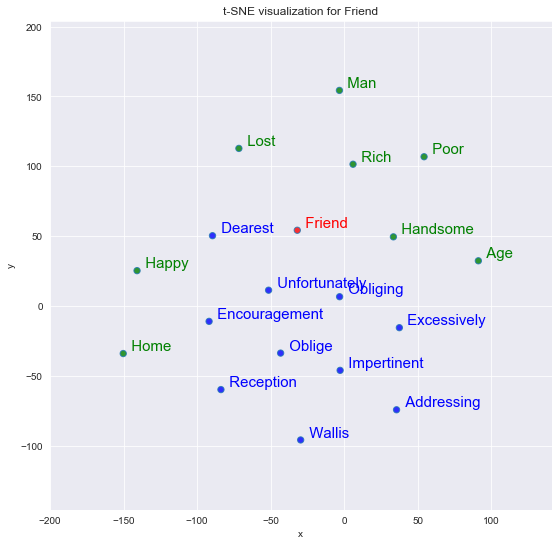

In [217]:
tsnescatterplot(w2v_model, 'friend', ['handsome', 'home', 'happy', 'rich', 'age', 'man', 'lost', 'poor'])

In [228]:

# BOW based approaches that includes averaging, summation, weighted addition. 
# The common way is to average the two word vectors. Therefore, we will follow the most common way.

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [229]:
#  Split senctences into array
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    


In [233]:
# train, test = train_test_split(df_clean, test_size=0.3, random_state = 42)

# test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['clean']), axis=1).values
# train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['clean']), axis=1).values

# X_train_word_average = word_averaging_list(wv,train_tokenized)
# X_test_word_average = word_averaging_list(wv,test_tokenized)

In [235]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(sentences, df_clean['author_id'],test_size=0.25,random_state=123)

In [239]:
X_train_w2v[4]

['lord', 'high', 'nations', 'glory', 'heavens']

In [244]:
X_train_w2v_average = word_averaging_list(w2v_model.wv,X_train_w2v)
X_test_w2v_average = word_averaging_list(w2v_model.wv,X_test_w2v)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()


In [246]:
#  Check if the word is in vocabulary -> count =5 -> not in vocab
word_freq ['prejudiced']

5

In [248]:
len(X_train_w2v_average[4])

300

In [252]:
# len(X_train_w2v_average)

#### Apply Naive Bayes model

In [255]:
naive_w2v = MultinomialNB()
classifier_w2v = naive_w2v.fit(X_train_w2v_average,y_train_w2v)
predict_w2v = classifier_w2v.predict(X_test_w2v_average)

ValueError: Input X must be non-negative

#### Apply LogisticRegression model

In [256]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_w2v_average,y_train_w2v)
predict_w2v = logreg.predict(X_test_w2v_average)
print('accuracy %s' % accuracy_score(predict_w2v,y_test_w2v))
print(classification_report(y_test_w2v, predict_w2v))

c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.7584464654452792
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3930
           1       0.90      0.96      0.93      7381
           2       0.49      0.26      0.34        95
           3       0.59      0.36      0.45       683
           4       0.74      0.59      0.66       230
           5       0.75      0.42      0.54       380
           6       0.66      0.68      0.67      2900
           7       0.64      0.57      0.61      2230
           8       0.69      0.63      0.66      2339
           9       0.74      0.58      0.65       443
          10       0.69      0.77      0.73      1120
          11       0.60      0.52      0.56      1030

    accuracy                           0.76     22761
   macro avg       0.69      0.60      0.63     22761
weighted avg       0.75      0.76      0.75     22761



In [257]:
docs_new_w2v = ['Even before Miss Taylor had ceased to hold the nominal office of governess',
                'Piping down the valleys wild',
                   'How sweet is the Shepherd sweet lot!',
                 'From the morn to the evening he stays',
                  "The sun does arise, And make happy the skies;  The merry bells ring To welcome the Spring;The skylark and thrush"
               ]
sent_test = [row.split() for row in docs_new_w2v ]
phrases_test = Phrases(sent_test, min_count=30, progress_per=10000)
bigram_test = Phraser(phrases_test)



# predicted = classifier_tfidf.predict(X_new_w2v)
# predicted

In [258]:
sentences_test = bigram_test[sent_test]

In [260]:
sentences_test[0]

['Even',
 'before',
 'Miss',
 'Taylor',
 'had',
 'ceased',
 'to',
 'hold',
 'the',
 'nominal',
 'office',
 'of',
 'governess']

In [261]:
test_model_w2v_average = word_averaging_list(w2v_model.wv,sentences_test)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()


In [265]:
# len(test_model_w2v_average[0])

In [263]:
predict_w2v_test = logreg.predict(test_model_w2v_average)

In [264]:
predict_w2v_test

array([1, 2, 2, 2, 2], dtype=int64)

In [267]:
counter  = 0
for doc, category in zip(docs_new_w2v, predict_w2v_test):
    print('%r => %s' % (doc, id_to_author_name[category]))
    if(counter == 10):
        break
    counter += 1    

'Even before Miss Taylor had ceased to hold the nominal office of governess' => bible
'Piping down the valleys wild' => blake
'How sweet is the Shepherd sweet lot!' => blake
'From the morn to the evening he stays' => blake
'The sun does arise, And make happy the skies;  The merry bells ring To welcome the Spring;The skylark and thrush' => blake


<img src="2019-12-21_2219.png" alt="drawing" width="400"/>

### Conclusion 

> Awesome , the model classify right for all test cases

> Not sure if  LogisticRegression is fitted to this data then Naive Bayes  or Vord2vec is better than TF-IDF and Bags of Word


# 8. Using LSA

 > We will use tfidf from the previous step  

In [ ]:
# tfidf_transformer = TfidfTransformer()
# X_tfidf = tfidf_transformer.fit_transform(train_data_features_bow)
# X_tfidf.shape

In [270]:
X_tfidf.shape

(98552, 41338)

In [318]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

svd = TruncatedSVD(n_components = 100)
X_lsa = svd.fit_transform(X_tfidf)

print (X_lsa)

[[ 0.00600533  0.0129159   0.01232843 ... -0.02512327 -0.10773555
   0.0433755 ]
 [ 0.00039497  0.00054291  0.00035489 ... -0.00018364 -0.00038773
   0.00059821]
 [ 0.00025768  0.00025344  0.00046008 ... -0.00003478  0.00043637
   0.00014694]
 ...
 [ 0.08194338  0.03683841  0.05224253 ... -0.00268316  0.02176731
   0.04615777]
 [ 0.024488    0.01316169  0.01038608 ... -0.0190526   0.00816015
   0.01941122]
 [ 0.0021525   0.00237353  0.00342804 ... -0.00203625 -0.00135266
   0.00490506]]


In [294]:
X_lsa.shape

(98552, 100)

In [327]:
X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, data['author_id'],test_size=0.25,random_state=123)

#### Print 10 words for each topic 

In [278]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    top_ten_words = ""
    for t in sorted_terms:
        top_ten_words = top_ten_words + " " + str(t[0])
    print(top_ten_words + " " ) 
        

Topic 0: 
 shall lord unto said thou thy thee god ye come 
Topic 1: 
 said oh unto king would well little mr know could 
Topic 2: 
 shall oh said ye know one see would say come 
Topic 3: 
 oh thou lord thy thee god shalt hast art thine 
Topic 4: 
 lord ye king israel unto god saith moses hath said 
Topic 5: 
 said shall unto oh thee thou lord thy shalt hast 
Topic 6: 
 ham said shall unto oh thee thou lord thy shalt 
Topic 7: 
 ye unto king say israel came god son come jesus 
Topic 8: 
 king shall came israel son house went judah david man 
Topic 9: 
 chapter ii iii unto man iv vi ix vii viii 
Topic 10: 
 know king ye thou lord well thy see shalt hast 
Topic 11: 
 man god know thou old son said every hath one 
Topic 12: 
 know unto say thee come god us well israel let 
Topic 13: 
 god thy let thee come us hath said good ye 
Topic 14: 
 come man thou let us go hast shalt lord see 
Topic 15: 
 god thou us say good would hast shall shalt art 
Topic 16: 
 say well man good king let thee go

#### Apply Random Forest

In [296]:
# X_test_lsa = svd.fit(X_test_tfidf)

In [320]:
X_train_lsa.shape

(73914, 100)

In [328]:


rf_lsa = RandomForestClassifier(class_weight="balanced")
rf_lsa.fit(X_train_lsa,y_train_lsa)
predict_lsa = rf_lsa.predict(X_test_lsa)
print('accuracy %s' % accuracy_score(predict_lsa,y_test_lsa))
print(classification_report(y_test_lsa, predict_lsa))

c:\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.5553616364964689
              precision    recall  f1-score   support

           0       0.49      0.67      0.57      4232
           1       0.75      0.90      0.82      7583
           2       0.19      0.04      0.06       107
           3       0.29      0.17      0.22       692
           4       0.30      0.18      0.23       259
           5       0.38      0.16      0.23       419
           6       0.36      0.38      0.37      3042
           7       0.33      0.23      0.27      2470
           8       0.42      0.32      0.36      2520
           9       0.38      0.11      0.17       473
          10       0.65      0.56      0.60      1790
          11       0.40      0.18      0.24      1051

    accuracy                           0.56     24638
   macro avg       0.41      0.33      0.35     24638
weighted avg       0.53      0.56      0.53     24638



### Test Model

In [329]:
docs_new_lsa = ['Even before Miss Taylor had ceased to hold the nominal office of governess',
                'Piping down the valleys wild',
                   'How sweet is the Shepherd sweet lot!',
                 'From the morn to the evening he stays',
                  "The sun does arise, And make happy the skies;  The merry bells ring To welcome the Spring;The skylark and thrush"
               ]
X_new_counts_lsa = vectorizer.transform(docs_new_lsa)
X_new_tranform_tfidf = tfidf_transformer.transform(X_new_counts_lsa)
X_new_test_lsa = svd.transform(X_new_tranform_tfidf)


predicted_lsa = rf_lsa.predict(X_new_test_lsa)
predicted_lsa

array([ 0, 11,  2,  0,  0], dtype=int64)

In [330]:
counter  = 0
for doc, category in zip(docs_new_lsa, predicted_lsa):
    print('%r => %s' % (doc, id_to_author_name[category]))
    if(counter == 10):
        break
    counter += 1   

'Even before Miss Taylor had ceased to hold the nominal office of governess' => austen
'Piping down the valleys wild' => whitman
'How sweet is the Shepherd sweet lot!' => blake
'From the morn to the evening he stays' => austen
'The sun does arise, And make happy the skies;  The merry bells ring To welcome the Spring;The skylark and thrush' => austen


### Apply with LogisticRegression

In [331]:
logreg_lsa = LogisticRegression(n_jobs=1, C=1e5)
logreg_lsa = logreg_lsa.fit(X_train_lsa,y_train_lsa)
predict_lsa = logreg_lsa.predict(X_test_lsa)
print('accuracy %s' % accuracy_score(predict_lsa,y_test_lsa))
print(classification_report(y_test_lsa, predict_lsa))

c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5880753307898369
              precision    recall  f1-score   support

           0       0.58      0.72      0.64      4232
           1       0.79      0.91      0.85      7583
           2       0.00      0.00      0.00       107
           3       0.42      0.11      0.17       692
           4       0.83      0.15      0.26       259
           5       0.84      0.15      0.25       419
           6       0.42      0.52      0.47      3042
           7       0.36      0.18      0.24      2470
           8       0.46      0.41      0.44      2520
           9       0.72      0.07      0.13       473
          10       0.41      0.66      0.51      1790
          11       0.39      0.07      0.12      1051

    accuracy                           0.59     24638
   macro avg       0.52      0.33      0.34     24638
weighted avg       0.57      0.59      0.55     24638



c:\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Conclusion

> This data work not really well wwith LSA